In [ ]:
!pip install torchcodec
!pip install -q git+https://github.com/openai/whisper.git pydub spacy soundfile speechbrain transformers datasets accelerate
!python -m spacy download en_core_web_sm
!apt-get -qq install ffmpeg
!pip install -q gradio
import gradio as gr
from google.colab import files



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


HINDI RE-DACT


✅ All required libraries appear available.
Using device: cuda
Loading models (this may take a minute)...
 - Whisper loaded.
 - spaCy loaded.
 - SpeechT5 (TTS) loaded.
 - Speaker embedding model loaded.
Creating a small reference speaker embedding (used for SpeechT5 voice control)...


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Speaker embedding ready.

Please select a file to upload (Colab upload dialog will appear).


Saving testaudi.mp3 to testaudi (1).mp3
Uploaded: testaudi (1).mp3

[Step 1/3] Converting audio to text with Whisper...

-> Original Transcript (preview):
 So, my name is Priya Sharma. Please send the documents to my email priya.sharma123 at example.go.in My account number is 8765432112. If you have any questions, my direct line is 212-555-0182. Thank you.
[Step 2/3] Detecting PII and redacting text...

📋 PII Detected Summary:
 - PERSON: Priya Sharma
 - EMAIL: priya.sharma123 at example.go.in
 - ACCOUNT: 8765432112
 - PHONE: 8765432112
 - PHONE: 212-555-0182

Redacted Text:
 So, my name is [PERSON]. Please send the documents to my email [EMAIL] My account number is [ACCOUNT]f you have any questions, my direct line is [PHONE]. Thank you.

Saved PII redaction summary to 'pii_redaction_summary.csv'
[Step 3/3] Converting redacted text to new audio (SpeechT5)...
Saved resynthesized audio to: resynthesized_redacted_audio.wav

✅ Pipeline finished. Now running EDA & evaluations...



/tmp/ipython-input-1359420692.py:324: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(input_filepath, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio Duration: 28.27 s, Sampling Rate: 48000 Hz


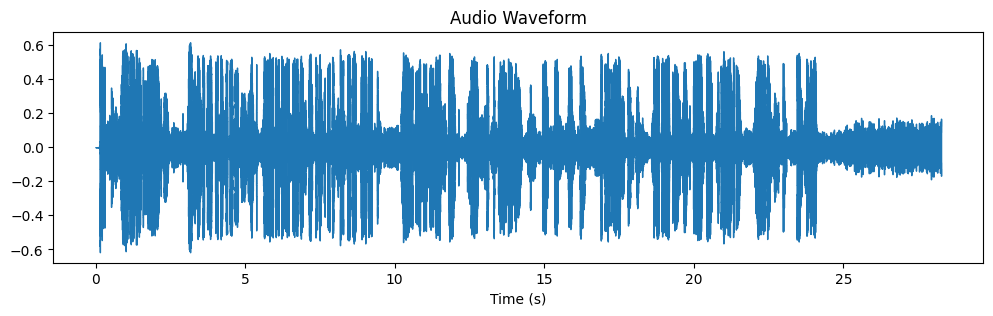

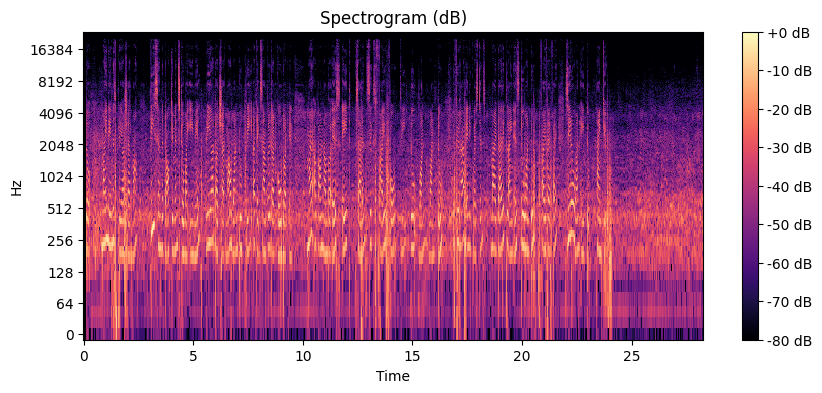


Text EDA:


,Metric,Original,After Redaction,Change (%)
0,Word Count,33,29,-12.121212
1,Unique Words,27,23,-14.814815
2,Bracketed Tags Count,0,4,400.000000


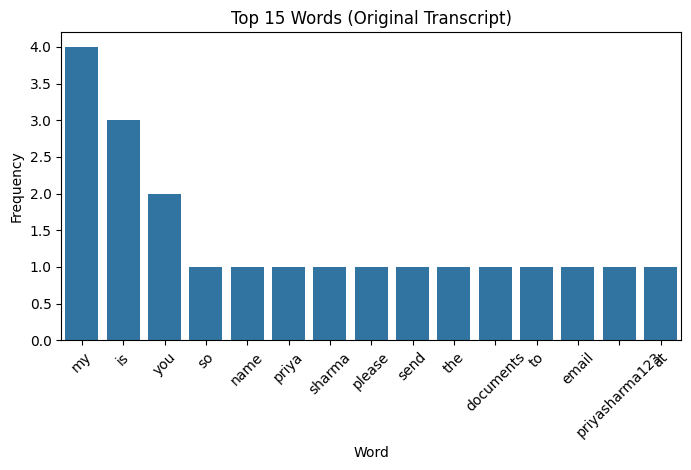

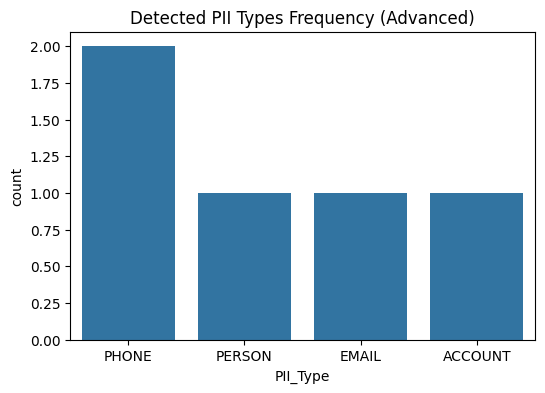


Baseline (regex-only) redactions found: 3
Advanced (regex + NER) redactions found: 5


,Model,Redacted Entities Count
0,Regex Baseline,3
1,Regex+NER Advanced,5


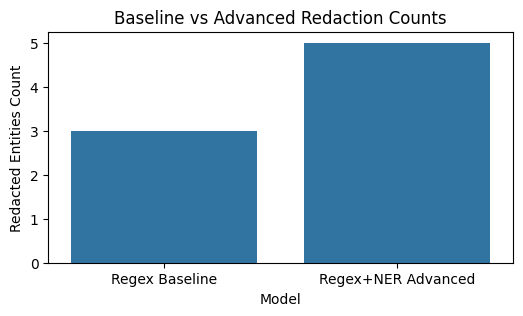

Saved baseline detection results to baseline_found.csv

PII Detection Evaluation (requires reference_entities.csv):
Advanced (Regex+NER) -> P: 1.00, R: 1.00, F1: 1.00
Baseline (Regex-only) -> P: 1.00, R: 0.50, F1: 0.67

ASR Metrics:
Word Error Rate (WER): 0.00%
Char Error Rate (CER): 0.00%

All done — outputs saved (original_transcript.txt, redacted_transcript.txt, pii_redaction_summary.csv (if PII found), resynthesized_redacted_audio.wav (if TTS succeeded), baseline_found.csv).


In [4]:
# Full end-to-end pipeline:
# - Installs deps (if missing)
# - Loads Whisper, spaCy, SpeechT5 + speaker model
# - Transcribes -> enhanced PII detection & redaction -> TTS resynthesis
# - Saves transcripts + pii_redaction_summary.csv
# - Runs EDA (audio waveform, spectrogram, text stats)
# - Runs baseline (regex-only) comparison
# - Optionally computes WER & CER using a manual reference.txt (if provided)
# - Optionally evaluates PII detection if a reference_entities.csv exists

import os
import sys
import subprocess
import re
import json
import math
from collections import Counter
from pathlib import Path

# -------------------------
# Setup / install packages
# -------------------------
def setup_environment():
    needed = [
        "git+https://github.com/openai/whisper.git",
        "spacy",
        "soundfile",
        "speechbrain==0.5.16",
        "torchcodec",
        "transformers",
        "datasets",
        "accelerate",
        "huggingface_hub",
        "torch",
        "torchcodec",
        "numpy",
        "jiwer",
        "librosa",
        "matplotlib",
        "seaborn",
        "pandas",
        "scikit-learn"
    ]
    try:
        import whisper, spacy, soundfile, speechbrain, torch, transformers, jiwer, librosa, matplotlib, seaborn, pandas
        # ensure spacy model exists
        try:
            spacy.load("en_core_web_sm")
        except:
            subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
        print("✅ All required libraries appear available.")
    except Exception as e:
        print("⏳ Installing missing libraries (this may take a while)...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + needed, check=True)
        # spacy language model
        subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
        print("✅ Libraries installed. Restart the kernel if necessary and re-run this cell.")

# Run installation check
setup_environment()

# -------------------------
# Imports after install
# -------------------------
import torch
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from collections import defaultdict
from jiwer import wer, cer
from sklearn.metrics import precision_score, recall_score, f1_score

# ML / model imports
import whisper
import spacy
from datasets import load_dataset
from speechbrain.pretrained import EncoderClassifier
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

# -------------------------
# Model & device settings
# -------------------------
WHISPER_MODEL_SIZE = "small.en"  # options: base.en, small.en, medium.en (tradeoff speed/quality)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -------------------------
# Load models (may take time)
# -------------------------
print("Loading models (this may take a minute)...")

# Whisper
whisper_model = whisper.load_model(WHISPER_MODEL_SIZE)
print(" - Whisper loaded.")

# spaCy
nlp = spacy.load("en_core_web_sm")
print(" - spaCy loaded.")

# SpeechT5 TTS
tts_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts").to(device)
tts_vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)
print(" - SpeechT5 (TTS) loaded.")

# Speaker embedding model (speechbrain)
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
speaker_model = EncoderClassifier.from_hparams(source=spk_model_name, run_opts={"device": device}, savedir=os.path.join("/tmp", spk_model_name))
print(" - Speaker embedding model loaded.")

# Create reference speaker embedding from LibriSpeech sample (fast streaming approach)
print("Creating a small reference speaker embedding (used for SpeechT5 voice control)...")
dataset = load_dataset("librispeech_asr", "clean", split="train.100", streaming=True)
sample = next(iter(dataset))
with torch.no_grad():
    audio_array = torch.tensor(sample["audio"]["array"]).unsqueeze(0).to(device)
    speaker_embeddings = speaker_model.encode_batch(audio_array)
    speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
    speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
speaker_embeddings = torch.tensor(speaker_embeddings).unsqueeze(0)
print("Speaker embedding ready.\n")

# -------------------------
# Enhanced PII detection patterns & functions
# -------------------------
PII_REGEX = {
    # handles 'user @ domain.com' and 'user at domain.com' with optional spaces around 'at' or '@'
    "EMAIL": r"\b[a-zA-Z0-9._%+-]+\s*(?:@|at)\s*[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b",
    # flexible phone pattern (US-style and international-ish, will match many 10-digit numbers)
    "PHONE": r"\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3}[-.\s]?\d{3,4}\b",
    # account-like numbers
    "ACCOUNT": r"\b\d{6,16}\b",
}

# Simpler baseline regex (naive) for comparison (does NOT handle 'at' instead of '@')
BASELINE_REGEX = {
    "EMAIL": r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b",
    "PHONE": r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b",
    "ACCOUNT": r"\b\d{6,16}\b",
}

def extract_with_regex(text, patterns):
    """Return list of (type, matched_text) found using provided regex pattern dict."""
    found = []
    for t, pat in patterns.items():
        for m in re.finditer(pat, text, flags=re.IGNORECASE):
            found.append({"type": t, "value": m.group(0), "start": m.start(), "end": m.end()})
    return found

def detect_and_redact_text_explainable(text, do_print=True):
    """
    Enhanced detection & redaction:
      - Uses regex patterns that handle 'at' for emails
      - Uses spaCy to detect PERSON entities
      - Returns (redacted_text, pii_summary_list)
    pii_summary_list: list of dicts {PII_Type, Original_Value}
    """
    if do_print:
        print("[Step 2/3] Detecting PII and redacting text...")

    entities = []

    # regex detections
    regex_entities = extract_with_regex(text, PII_REGEX)
    entities.extend(regex_entities)

    # spaCy PERSON detection
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entities.append({"type": "PERSON", "value": ent.text, "start": ent.start_char, "end": ent.end_char})

    if not entities:
        if do_print:
            print("⚠️ No PII detected.")
        return text, []

    # Sort by start index descending to safely replace
    entities_sorted = sorted(entities, key=lambda x: x.get("start", 0), reverse=True)

    redacted_text = text
    pii_summary = []
    for e in entities_sorted:
        st = e.get("start", None)
        en = e.get("end", None)
        val = e["value"]
        typ = e["type"]

        if st is None or en is None:
            # fallback: attempt to find the first occurrence of value
            idx = redacted_text.lower().find(val.lower())
            if idx >= 0:
                st = idx
                en = idx + len(val)
            else:
                continue

        # replace the span with tag
        redacted_text = redacted_text[:st] + f"[{typ}]" + redacted_text[en:]

        # log the pii (we keep original value in summary)
        pii_summary.append({"PII_Type": typ, "Original_Value": val})

    # reverse so the summary reads left-to-right
    pii_summary.reverse()

    if do_print and pii_summary:
        print("\n📋 PII Detected Summary:")
        for item in pii_summary:
            print(f" - {item['PII_Type']}: {item['Original_Value']}")

    return redacted_text, pii_summary

def regex_only_redaction(text, patterns=BASELINE_REGEX):
    """Baseline redaction using simple regex patterns (naive)."""
    red = text
    found = []
    for t, pat in patterns.items():
        red = re.sub(pat, f"[{t}]", red, flags=re.IGNORECASE)
        for m in re.finditer(pat, text, flags=re.IGNORECASE):
            found.append({"type": t, "value": m.group(0)})
    return red, found

# -------------------------
# Transcription & TTS
# -------------------------
def transcribe_audio(filepath):
    print("\n[Step 1/3] Converting audio to text with Whisper...")
    res = whisper_model.transcribe(filepath)
    return res["text"]

def synthesize_speech(text, out_filename="resynthesized_redacted_audio.wav", samplerate=16000):
    print("[Step 3/3] Converting redacted text to new audio (SpeechT5)...")
    # you can customize the greeting or remove it
    greeting = "Here is the redacted audio. "
    full_text = greeting + text

    inputs = tts_processor(text=full_text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)

    speaker_embeddings_device = speaker_embeddings.to(device)
    with torch.no_grad():
        speech = tts_model.generate_speech(input_ids, speaker_embeddings_device, vocoder=tts_vocoder)
    speech_np = speech.cpu().numpy()
    sf.write(out_filename, speech_np, samplerate=samplerate)
    print(f"Saved resynthesized audio to: {out_filename}")
    return out_filename

# -------------------------
# File upload helper (Colab-safe)
# -------------------------
def upload_or_choose_file():
    """
    Tries to use google.colab.files.upload(); if not available, asks the user to input a local path.
    Returns a local filepath string.
    """
    try:
        from google.colab import files
        print("Please select a file to upload (Colab upload dialog will appear).")
        uploaded = files.upload()
        if not uploaded:
            raise Exception("No file uploaded.")
        fname = list(uploaded.keys())[0]
        print(f"Uploaded: {fname}")
        return fname
    except Exception:
        # fallback to local path
        p = input("Enter path to your audio file (WAV/MP3/M4A): ").strip()
        if not os.path.exists(p):
            raise FileNotFoundError(f"File not found: {p}")
        return p

# -------------------------
# Main execution
# -------------------------
def main_pipeline():
    # 1) get input audio file
    input_filepath = upload_or_choose_file()

    # 2) transcribe
    original_text = transcribe_audio(input_filepath)
    print("\n-> Original Transcript (preview):")
    print(original_text)

    # Save original transcript
    with open("original_transcript.txt", "w", encoding="utf-8") as f:
        f.write(original_text)

    # 3) detect & redact (enhanced)
    redacted_text, pii_summary = detect_and_redact_text_explainable(original_text)
    print("\n" + "="*50)
    print("Redacted Text:")
    print(redacted_text)
    print("="*50 + "\n")

    # Save redacted transcript
    with open("redacted_transcript.txt", "w", encoding="utf-8") as f:
        f.write(redacted_text)

    # Save the pii summary CSV for later EDA
    if pii_summary:
        pd.DataFrame(pii_summary).to_csv("pii_redaction_summary.csv", index=False)
        print("Saved PII redaction summary to 'pii_redaction_summary.csv'")
    else:
        print("No PII summary to save.")

    # 4) synthesize TTS from redacted text
    try:
        out_audio = synthesize_speech(redacted_text, out_filename="resynthesized_redacted_audio.wav", samplerate=16000)
    except Exception as e:
        print("⚠️ TTS generation failed:", e)
        out_audio = None

    print("\n✅ Pipeline finished. Now running EDA & evaluations...\n")

    # -------------------------
    # EDA: Audio exploration
    # -------------------------
    try:
        y, sr = librosa.load(input_filepath, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        print(f"Audio Duration: {duration:.2f} s, Sampling Rate: {sr} Hz")
        plt.figure(figsize=(12, 3))
        librosa.display.waveshow(y, sr=sr)
        plt.title("Audio Waveform")
        plt.xlabel("Time (s)")
        plt.show()

        # Spectrogram
        plt.figure(figsize=(10, 4))
        D = np.abs(librosa.stft(y))
        db = librosa.amplitude_to_db(D, ref=np.max)
        librosa.display.specshow(db, sr=sr, x_axis="time", y_axis="log")
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram (dB)")
        plt.show()
    except Exception as e:
        print("Audio EDA failed:", e)

    # -------------------------
    # EDA: Text exploration
    # -------------------------
    print("\nText EDA:")
    orig_words = original_text.split()
    red_words = redacted_text.split()
    df_stats = pd.DataFrame({
        "Metric": ["Word Count", "Unique Words", "Bracketed Tags Count"],
        "Original": [len(orig_words), len(set([w.lower().strip('.,?!') for w in orig_words])), original_text.count('[')],
        "After Redaction": [len(red_words), len(set([w.lower().strip('.,?!') for w in red_words])), redacted_text.count('[')]
    })
    df_stats["Change (%)"] = 100 * (df_stats["After Redaction"] - df_stats["Original"]) / df_stats["Original"].replace({0:1})
    display(df_stats)

    # Word frequency
    wordlist = [re.sub(r"[^\w']","", w).lower() for w in orig_words]
    freq = Counter([w for w in wordlist if w])
    common = pd.DataFrame(freq.most_common(15), columns=["Word","Frequency"])
    plt.figure(figsize=(8,4))
    sns.barplot(data=common, x="Word", y="Frequency")
    plt.title("Top 15 Words (Original Transcript)")
    plt.xticks(rotation=45)
    plt.show()

    # -------------------------
    # PII Summary visualization (if exists)
    # -------------------------
    if os.path.exists("pii_redaction_summary.csv"):
        df_pii = pd.read_csv("pii_redaction_summary.csv")
        plt.figure(figsize=(6,4))
        order = df_pii["PII_Type"].value_counts().index
        sns.countplot(data=df_pii, x="PII_Type", order=order)
        plt.title("Detected PII Types Frequency (Advanced)")
        plt.show()
    else:
        print("No pii_redaction_summary.csv available for visualization.")

    # -------------------------
    # Baseline comparison: regex-only (naive)
    # -------------------------
    baseline_text, baseline_found = regex_only_redaction(original_text, patterns=BASELINE_REGEX)
    baseline_count = len(baseline_found)
    advanced_count = len(pii_summary)
    print("\nBaseline (regex-only) redactions found:", baseline_count)
    print("Advanced (regex + NER) redactions found:", advanced_count)

    comp_df = pd.DataFrame({
        "Model": ["Regex Baseline", "Regex+NER Advanced"],
        "Redacted Entities Count": [baseline_count, advanced_count]
    })
    display(comp_df)
    plt.figure(figsize=(6,3))
    sns.barplot(data=comp_df, x="Model", y="Redacted Entities Count")
    plt.title("Baseline vs Advanced Redaction Counts")
    plt.show()

    # Save baseline results as JSON for debugging
    pd.DataFrame(baseline_found).to_csv("baseline_found.csv", index=False)
    print("Saved baseline detection results to baseline_found.csv")

    # -------------------------
    # PII detection evaluation (if reference entities provided)
    # -------------------------
    if os.path.exists("reference_entities.csv"):
        # reference_entities.csv should have column: Original_Value (exact text of PIIs)
        ref = pd.read_csv("reference_entities.csv")
        gt_values = [str(x).strip().lower() for x in ref["Original_Value"].tolist()]

        # detected lists
        adv_detected_vals = [str(x["Original_Value"]).strip().lower() for x in pii_summary]
        baseline_detected_vals = [str(x["value"]).strip().lower() for x in baseline_found]

        # compute simple matching-based precision/recall/f1
        def get_metrics(detected, gt):
            y_true = []
            y_pred = []
            for v in gt:
                y_true.append(1)
                y_pred.append(1 if any(v in d for d in detected) else 0)
            # handle edge cases when no gt
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            return precision, recall, f1

        adv_prec, adv_rec, adv_f1 = get_metrics(adv_detected_vals, gt_values)
        base_prec, base_rec, base_f1 = get_metrics(baseline_detected_vals, gt_values)

        print("\nPII Detection Evaluation (requires reference_entities.csv):")
        print("Advanced (Regex+NER) -> P: {:.2f}, R: {:.2f}, F1: {:.2f}".format(adv_prec, adv_rec, adv_f1))
        print("Baseline (Regex-only) -> P: {:.2f}, R: {:.2f}, F1: {:.2f}".format(base_prec, base_rec, base_f1))
    else:
        print("\nNo 'reference_entities.csv' found for PII detection metrics. To evaluate, create one with a column 'Original_Value' containing ground-truth PII strings.")

    # -------------------------
    # ASR evaluation: WER / CER (if reference.txt exists)
    # -------------------------
    if os.path.exists("reference.txt"):
        with open("reference.txt", "r", encoding="utf-8") as f:
            reference_text = f.read().strip().lower()
        hypothesis_text = original_text.strip().lower()
        wer_score = wer(reference_text, hypothesis_text)
        cer_score = cer(reference_text, hypothesis_text)
        print("\nASR Metrics:")
        print(f"Word Error Rate (WER): {wer_score*100:.2f}%")
        print(f"Char Error Rate (CER): {cer_score*100:.2f}%")
    else:
        print("\nNo 'reference.txt' found for ASR metrics (WER/CER). To compute WER, create 'reference.txt' containing correct transcript.")

    print("\nAll done — outputs saved (original_transcript.txt, redacted_transcript.txt, pii_redaction_summary.csv (if PII found), resynthesized_redacted_audio.wav (if TTS succeeded), baseline_found.csv).")

# Run the whole pipeline
if __name__ == "__main__":
    main_pipeline()


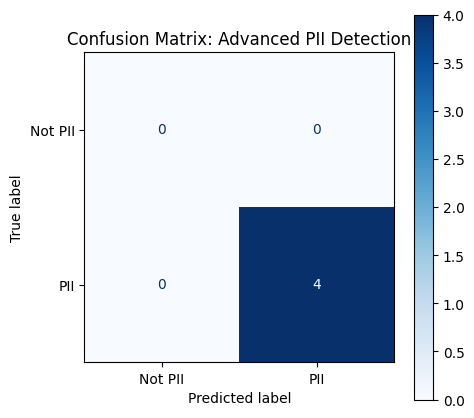

Classification Report:

              precision    recall  f1-score   support

     Not PII       0.00      0.00      0.00         0
         PII       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       0.50      0.50      0.50         4
weighted avg       1.00      1.00      1.00         4



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# -------------------------
# Load data
# -------------------------
df_ref = pd.read_csv("reference_entities.csv")  # Ground-truth
df_detected = pd.read_csv("pii_redaction_summary.csv")  # Detected

gt_values = [str(x).strip().lower() for x in df_ref["Original_Value"]]
detected_values = [str(x).strip().lower() for x in df_detected["Original_Value"]]

# -------------------------
# Prepare y_true and y_pred
# -------------------------
y_true = []
y_pred = []

for val in gt_values:
    y_true.append(1)
    y_pred.append(1 if any(val in d for d in detected_values) else 0)

fp_values = [d for d in detected_values if d not in gt_values]
y_true += [0]*len(fp_values)
y_pred += [1]*len(fp_values)

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not PII", "PII"])

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix: Advanced PII Detection")
plt.show()

# -------------------------
# Classification Report (robust version)
# -------------------------
labels = [0, 1]  # all possible labels
report = classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=["Not PII", "PII"],
    zero_division=0  # avoid divide-by-zero warning
)

print("Classification Report:\n")
print(report)


In [2]:
# Create reference.txt with the correct transcript
reference_transcript = """So, my name is Priya Sharma. Please send the documents to my email priya.sharma123 at example.go.in My account number is 8765432112. If you have any questions, my direct line is 212-555-0182. Thank you."""
with open("reference.txt", "w", encoding="utf-8") as f:
    f.write(reference_transcript)

print("✅ reference.txt created!")


✅ reference.txt created!


In [3]:
import pandas as pd

# Example: ground-truth PII values
pii_ground_truth = {
    "Original_Value": [
        "Priya Sharma",
        "priya.sharma123 at example.go.in",
        "8765432112",
        "212-555-0182"
    ]
}

df_pii = pd.DataFrame(pii_ground_truth)
df_pii.to_csv("reference_entities.csv", index=False)
print("✅ reference_entities.csv created!")


✅ reference_entities.csv created!


In [ ]:
!ls


reference_entities.csv	reference.txt  sample_data


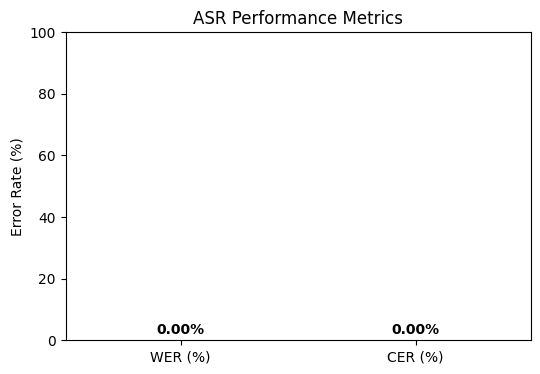

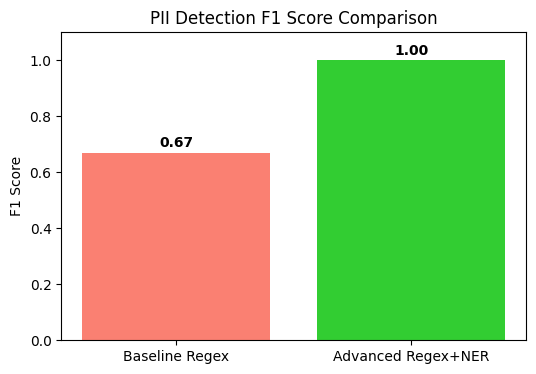

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Metrics (fill in your numbers)
# -------------------------
asr_metrics = {
    "Metric": ["WER (%)", "CER (%)"],
    "Value": [0.0, 0.0]
}

pii_metrics = {
    "Model": ["Baseline Regex", "Advanced Regex+NER"],
    "F1_Score": [0.67, 1.00]
}

# -------------------------
# Plot ASR Metrics
# -------------------------
df_asr = pd.DataFrame(asr_metrics)

plt.figure(figsize=(6,4))
plt.bar(df_asr["Metric"], df_asr["Value"], color=["orange", "skyblue"])
plt.ylim(0, 100)
plt.title("ASR Performance Metrics")
plt.ylabel("Error Rate (%)")
for i, v in enumerate(df_asr["Value"]):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

# -------------------------
# Plot PII F1 Scores
# -------------------------
df_pii = pd.DataFrame(pii_metrics)

plt.figure(figsize=(6,4))
plt.bar(df_pii["Model"], df_pii["F1_Score"], color=["salmon", "limegreen"])
plt.ylim(0, 1.1)
plt.title("PII Detection F1 Score Comparison")
plt.ylabel("F1 Score")
for i, v in enumerate(df_pii["F1_Score"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()
